# Assignment 2: COMPSCI 7318 Deep Learning Fundamentals

by Jack Hetherington

Due date: 11.59pm, 10 October 2024

# Import packages

In [10]:
#Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import resnet18, efficientnet_b0, mobilenet_v2, efficientnet_b7
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchsummary import summary
import time

import warnings
warnings.filterwarnings("ignore")

# Import, pre-process and split data


* Set device
* Define transformation and augmentation
* Load and split data
* Set batch sizes
* Inspect data


In [2]:
#Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#Data transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

#Load CIFAR-10 dataset
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

#Split train set for validation
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_set, val_set = random_split(train_set, [train_size, val_size])

#Data loaders
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 49.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
#Display general information about the dataset
print(f"Training set size: {len(train_set)} images")
print(f"Validation set size: {len(val_set)} images")
print(f"Test set size: {len(test_set)} images")
print(f"Number of classes: {len(train_set.dataset.classes)}")

#Display class names
print("Classes:", train_set.dataset.classes)

sample_image, _ = train_set[0]  #Get the first image from the training set
print(f"Image dimensions: {sample_image.shape}")

Training set size: 40000 images
Validation set size: 10000 images
Test set size: 10000 images
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Image dimensions: torch.Size([3, 32, 32])


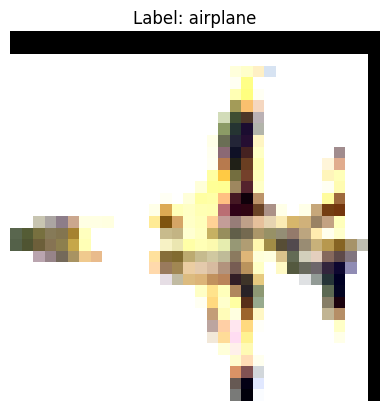

In [5]:
#Display an example image and label
def show_example(data_loader):
    images, labels = next(iter(data_loader))
    img = images[0]
    label = labels[0]

    img = img * 0.5 + 0.5  #unnormalise
    img = img.permute(1, 2, 0)  #rearrange dimensions for matplotlib (HWC)

    plt.imshow(img)
    plt.title(f"Label: {train_set.dataset.classes[label]}")
    plt.axis('off')
    plt.show()

show_example(val_loader)

# Initialise models and define training functions




Models:
1. EfficientNet-B0
2. ResNet18
3. MobileNet

Hyperparameters:

* Optimiser: Adam
* Regularisation: Weight decay (L2)
* Learning rate: 0.001
* Loss function: Cross-entropy
* Number of epochs: 20
* Batch size: 64


In [6]:
#Initialise models
model_efficientnet = efficientnet_b0(pretrained=False, num_classes=10).to(device)
model_resnet = resnet18(pretrained=False, num_classes=10).to(device)
model_mobilenet = mobilenet_v2(pretrained=False, num_classes=10).to(device)

In [7]:
#Training function
def train_model(model, criterion, optimiser, train_loader, val_loader, num_epochs=20):
    train_acc, val_acc = [], [] #lists to store training data
    train_loss, val_loss = [], []

    total_start_time = time.time() #initiate start time

    for epoch in range(num_epochs):
        epoch_start_time = time.time()  #start the timer for each epoch

        model.train() #train model for this epoch
        correct, total, running_loss = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device) #move data to device
            optimiser.zero_grad() #reset gradients
            outputs = model(inputs) #forward pass output calculation
            loss = criterion(outputs, labels) #compute losses
            loss.backward() #compute gradients thrgouh backward pass
            optimiser.step() #update weights

            running_loss += loss.item() #accumulate losses for batch
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        #calculate predictions and accuracy
        train_acc_epoch = 100 * correct / total
        train_loss_epoch = running_loss / len(train_loader)
        train_acc.append(train_acc_epoch)
        train_loss.append(train_loss_epoch)

        #validation phase
        model.eval()
        val_correct, val_total, val_running_loss = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs) #forward pass
                loss = criterion(outputs, labels) #calculate loss
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        #calculate predictions and accuracy
        val_acc_epoch = 100 * val_correct / val_total
        val_loss_epoch = val_running_loss / len(val_loader)
        val_acc.append(val_acc_epoch)
        val_loss.append(val_loss_epoch)

        #end the epoch timer and calculate elapsed time
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time

        #print progress with epoch time
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss_epoch:.4f}, Train Acc: {train_acc_epoch:.2f}%, "
              f"Val Loss: {val_loss_epoch:.4f}, Val Acc: {val_acc_epoch:.2f}%, "
              f"Time: {epoch_time:.2f} seconds")

    #end the total training timer and calculate total time
    total_end_time = time.time()
    total_training_time = total_end_time - total_start_time
    print(f"\nTotal Training Time: {total_training_time:.2f} seconds")

    return train_acc, val_acc, train_loss, val_loss

#Validation function
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy


#Plotting training and validation curves
def plot_results(train_acc, val_acc, train_loss, val_loss):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [8]:
#Hyperparameters
criterion = nn.CrossEntropyLoss()
num_epochs = 20

# Train and evaluate models

Evaluation:
* Accuracy: training, validation and test data
* Training time
* No. of parameters


## EfficientNet-B0

In [ ]:
optimiser = optim.Adam(model_efficientnet.parameters(), lr=0.001, weight_decay=5e-4)

#train model
train_acc, val_acc, train_loss, val_loss = train_model(
    model_efficientnet, criterion, optimiser, train_loader, val_loader, num_epochs
)


Epoch [1/20], Train Loss: 2.8643, Train Acc: 16.34%, Val Loss: 2.3262, Val Acc: 23.73%, Time: 64.70 seconds
Epoch [2/20], Train Loss: 2.3711, Train Acc: 23.26%, Val Loss: 2.1063, Val Acc: 27.25%, Time: 47.19 seconds
Epoch [3/20], Train Loss: 2.3323, Train Acc: 23.58%, Val Loss: 1.9986, Val Acc: 23.51%, Time: 47.07 seconds
Epoch [4/20], Train Loss: 2.3169, Train Acc: 22.32%, Val Loss: 2.1158, Val Acc: 26.56%, Time: 45.83 seconds
Epoch [5/20], Train Loss: 2.2165, Train Acc: 27.03%, Val Loss: 3.6940, Val Acc: 29.62%, Time: 45.63 seconds
Epoch [6/20], Train Loss: 2.1212, Train Acc: 29.85%, Val Loss: 2.2767, Val Acc: 35.74%, Time: 45.36 seconds
Epoch [7/20], Train Loss: 2.0920, Train Acc: 30.97%, Val Loss: 1.9899, Val Acc: 35.07%, Time: 44.94 seconds
Epoch [8/20], Train Loss: 1.9803, Train Acc: 33.96%, Val Loss: 3.3429, Val Acc: 35.51%, Time: 45.21 seconds
Epoch [9/20], Train Loss: 1.9972, Train Acc: 32.25%, Val Loss: 2.1046, Val Acc: 36.25%, Time: 46.37 seconds
Epoch [10/20], Train Loss: 2

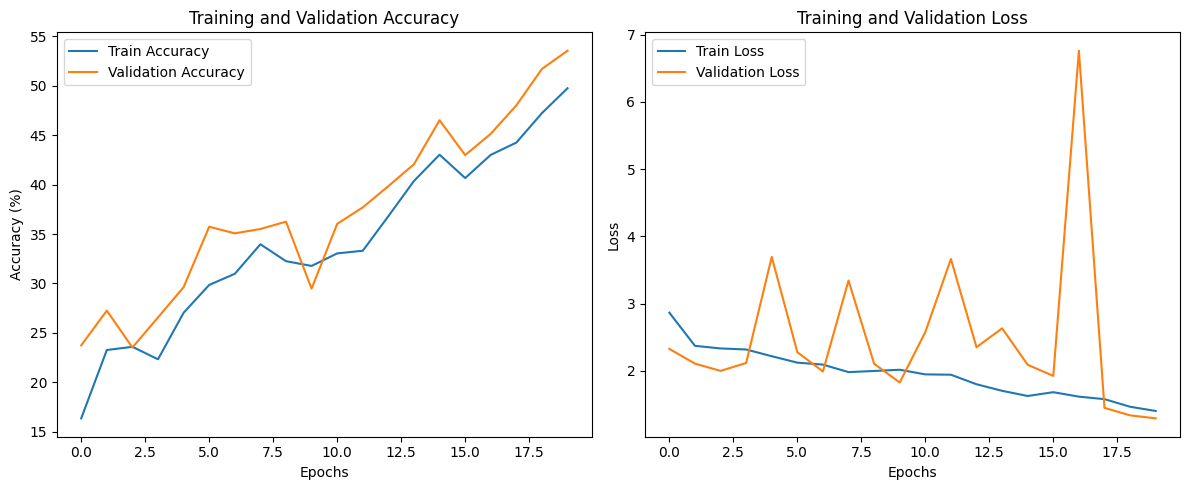


Evaluating EfficientNet-B0 on Test Set...
Test Accuracy: 54.60%


In [ ]:
#plot results
plot_results(train_acc, val_acc, train_loss, val_loss)

#test performance
print('\nEvaluating EfficientNet-B0 on Test Set...')
test_accuracy = test_model(model_efficientnet, test_loader)

In [ ]:
print("\nEfficientNet Summary:")
summary(model_efficientnet, (3, 32, 32))


EfficientNet Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              SiLU-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]             288
       BatchNorm2d-5           [-1, 32, 16, 16]              64
              SiLU-6           [-1, 32, 16, 16]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 16, 16, 16]             512
      BatchNorm2

## ResNet-18

In [ ]:
optimiser = optim.Adam(model_resnet.parameters(), lr=0.001, weight_decay=5e-4)

#train model
train_acc, val_acc, train_loss, val_loss = train_model(
    model_resnet, criterion, optimiser, train_loader, val_loader, num_epochs
)

Epoch [1/20], Train Loss: 1.5978, Train Acc: 42.13%, Val Loss: 1.4531, Val Acc: 48.75%, Time: 36.59 seconds
Epoch [2/20], Train Loss: 1.2673, Train Acc: 54.72%, Val Loss: 1.2629, Val Acc: 55.61%, Time: 36.48 seconds
Epoch [3/20], Train Loss: 1.1293, Train Acc: 59.98%, Val Loss: 1.1415, Val Acc: 59.81%, Time: 36.85 seconds
Epoch [4/20], Train Loss: 1.0363, Train Acc: 63.53%, Val Loss: 1.0022, Val Acc: 64.97%, Time: 35.47 seconds
Epoch [5/20], Train Loss: 0.9679, Train Acc: 66.35%, Val Loss: 1.0509, Val Acc: 63.55%, Time: 36.59 seconds
Epoch [6/20], Train Loss: 0.9089, Train Acc: 68.28%, Val Loss: 0.9440, Val Acc: 67.63%, Time: 36.16 seconds
Epoch [7/20], Train Loss: 0.8653, Train Acc: 70.14%, Val Loss: 0.8764, Val Acc: 70.19%, Time: 34.91 seconds
Epoch [8/20], Train Loss: 0.8260, Train Acc: 71.64%, Val Loss: 0.8429, Val Acc: 70.37%, Time: 35.03 seconds
Epoch [9/20], Train Loss: 0.7937, Train Acc: 72.89%, Val Loss: 0.8360, Val Acc: 71.00%, Time: 35.90 seconds
Epoch [10/20], Train Loss: 0

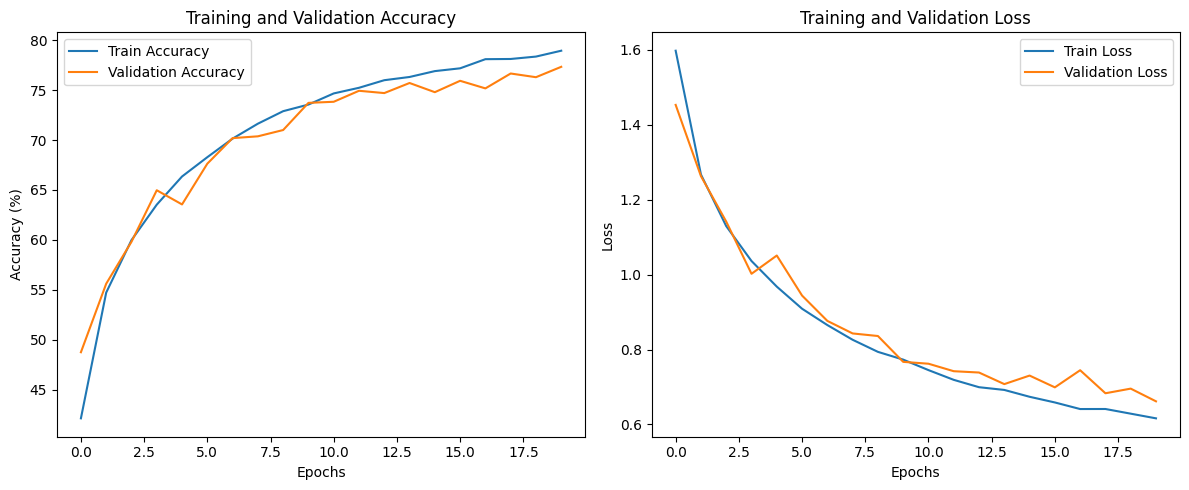


Evaluating ResNet-18 on Test Set...
Test Accuracy: 78.34%


In [ ]:
#plot results
plot_results(train_acc, val_acc, train_loss, val_loss)

#test performance
print('\nEvaluating ResNet-18 on Test Set...')
test_accuracy = test_model(model_resnet, test_loader)

In [ ]:
print("\nResNet-18 Summary:")
summary(model_resnet, (3, 32, 32))


ResNet-18 Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-1

## MobileNet

In [ ]:
optimiser = optim.Adam(model_mobilenet.parameters(), lr=0.001, weight_decay=5e-4)

#train model
train_acc, val_acc, train_loss, val_loss = train_model(
    model_mobilenet, criterion, optimiser, train_loader, val_loader, num_epochs
)


Epoch [1/20], Train Loss: 2.0004, Train Acc: 24.23%, Val Loss: 1.7859, Val Acc: 32.18%, Time: 39.26 seconds
Epoch [2/20], Train Loss: 1.7049, Train Acc: 35.80%, Val Loss: 1.5944, Val Acc: 42.78%, Time: 39.53 seconds
Epoch [3/20], Train Loss: 1.5579, Train Acc: 42.57%, Val Loss: 1.5238, Val Acc: 44.99%, Time: 39.65 seconds
Epoch [4/20], Train Loss: 1.4474, Train Acc: 47.45%, Val Loss: 1.3616, Val Acc: 51.46%, Time: 39.60 seconds
Epoch [5/20], Train Loss: 1.3499, Train Acc: 51.58%, Val Loss: 1.2895, Val Acc: 53.77%, Time: 38.84 seconds
Epoch [6/20], Train Loss: 1.2652, Train Acc: 54.90%, Val Loss: 1.2020, Val Acc: 57.00%, Time: 38.45 seconds
Epoch [7/20], Train Loss: 1.1886, Train Acc: 58.06%, Val Loss: 1.1372, Val Acc: 59.46%, Time: 38.97 seconds
Epoch [8/20], Train Loss: 1.1311, Train Acc: 60.09%, Val Loss: 1.0630, Val Acc: 62.48%, Time: 39.30 seconds
Epoch [9/20], Train Loss: 1.0762, Train Acc: 61.88%, Val Loss: 1.0732, Val Acc: 61.98%, Time: 38.34 seconds
Epoch [10/20], Train Loss: 1

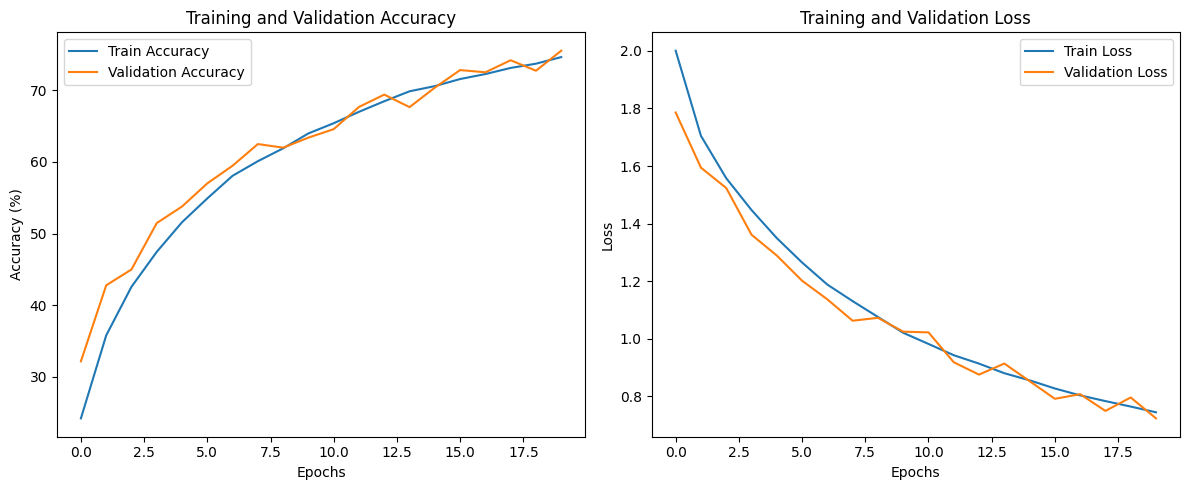


Evaluating MobileNet on Test Set...
Test Accuracy: 76.32%


In [ ]:
#plot results
plot_results(train_acc, val_acc, train_loss, val_loss)

#test performance
print('\nEvaluating MobileNet on Test Set...')
test_accuracy = test_model(model_mobilenet, test_loader)

In [ ]:
print("\nMobileNet Summary:")
summary(model_mobilenet, (3, 32, 32))


MobileNet Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
             ReLU6-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]             288
       BatchNorm2d-5           [-1, 32, 16, 16]              64
             ReLU6-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 16, 16, 16]             512
       BatchNorm2d-8           [-1, 16, 16, 16]              32
  InvertedResidual-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 96, 16, 16]           1,536
      BatchNorm2d-11           [-1, 96, 16, 16]             192
            ReLU6-12           [-1, 96, 16, 16]               0
           Conv2d-13             [-1, 96, 8, 8]             864
      BatchNorm2d-1

#Further experimenting

Trialling EfficientNet-B7

In [11]:
model_efficientnet_b7 = efficientnet_b7(pretrained=False, num_classes=10).to(device)
optimiser = optim.Adam(model_efficientnet_b7.parameters(), lr=0.001, weight_decay=5e-4)

#train model
train_acc, val_acc, train_loss, val_loss = train_model(
    model_efficientnet_b7, criterion, optimiser, train_loader, val_loader, num_epochs
)


Epoch [1/20], Train Loss: 3.8353, Train Acc: 10.17%, Val Loss: 2.3140, Val Acc: 9.85%, Time: 128.20 seconds
Epoch [2/20], Train Loss: 3.4717, Train Acc: 10.36%, Val Loss: 7.3565, Val Acc: 9.84%, Time: 126.05 seconds
Epoch [3/20], Train Loss: 3.2754, Train Acc: 10.70%, Val Loss: 3.3450, Val Acc: 11.62%, Time: 126.33 seconds
Epoch [4/20], Train Loss: 3.1215, Train Acc: 10.50%, Val Loss: 3.6057, Val Acc: 10.80%, Time: 125.22 seconds
Epoch [5/20], Train Loss: 3.1499, Train Acc: 10.25%, Val Loss: 3.3174, Val Acc: 10.32%, Time: 126.28 seconds
Epoch [6/20], Train Loss: 3.1007, Train Acc: 10.54%, Val Loss: 6.4043, Val Acc: 11.03%, Time: 125.61 seconds
Epoch [7/20], Train Loss: 2.9820, Train Acc: 10.60%, Val Loss: 3408.3962, Val Acc: 11.02%, Time: 125.04 seconds
Epoch [8/20], Train Loss: 2.9848, Train Acc: 10.22%, Val Loss: 3.6042, Val Acc: 9.89%, Time: 126.26 seconds
Epoch [9/20], Train Loss: 2.7396, Train Acc: 11.10%, Val Loss: 3.0556, Val Acc: 13.04%, Time: 126.32 seconds
Epoch [10/20], Trai

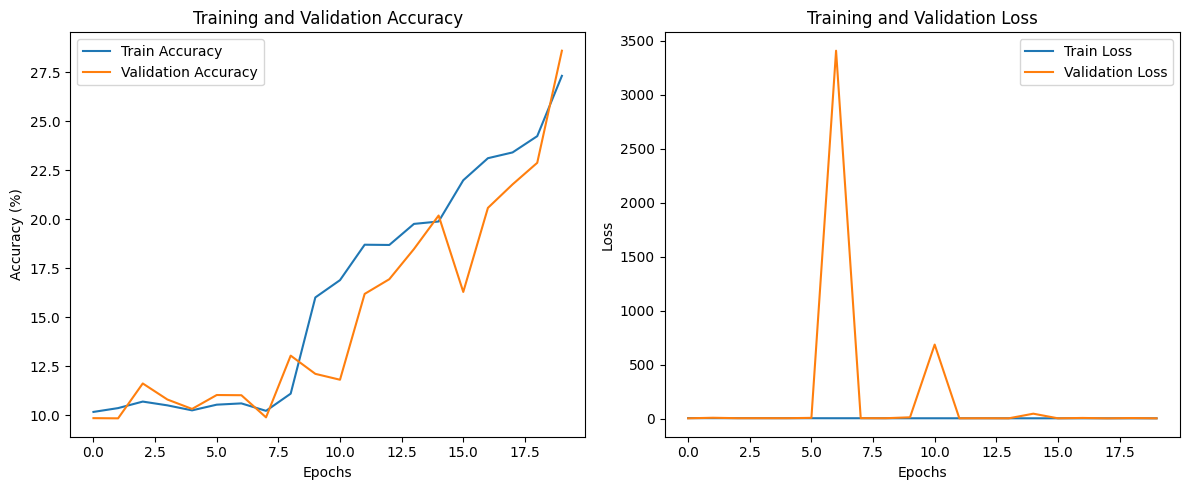


Evaluating ResNet-18 on Test Set...
Test Accuracy: 30.35%


In [12]:
#plot results
plot_results(train_acc, val_acc, train_loss, val_loss)

#test performance
print('\nEvaluating ResNet-18 on Test Set...')
test_accuracy = test_model(model_efficientnet_b7, test_loader)

In [13]:
print("\nMobileNet Summary:")
summary(model_efficientnet_b7, (3, 32, 32))


MobileNet Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,728
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              SiLU-3           [-1, 64, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]             576
       BatchNorm2d-5           [-1, 64, 16, 16]             128
              SiLU-6           [-1, 64, 16, 16]               0
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]               0
            Conv2d-8             [-1, 16, 1, 1]           1,040
              SiLU-9             [-1, 16, 1, 1]               0
           Conv2d-10             [-1, 64, 1, 1]           1,088
          Sigmoid-11             [-1, 64, 1, 1]               0
SqueezeExcitation-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 32, 16, 16]           2,048
      BatchNorm2d-1